In [75]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
!pip install cyipopt
import ipopt
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


### Buy and Hold Strategy 

In [103]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
  interest = 0
  x_optimal = x_init 
  cash_optimal = cash_init 
  return x_optimal, cash_optimal, interest

### Equally Weighted Strategy

In [104]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices): 
    # Set the interst as 0
    interest = 0
    # Calculate the portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    # Set the number of stock euqal to 20 
    num_stock = 20
    # Equal weight
    weight_equal = np.ones((20))/num_stock
    # Equally allocate the wealth value for each stock
    value_each_stock = weight_equal * port_value
    # Calculate corresponding shares for each stock 
    x_optimal = np.floor(value_each_stock / cur_prices)
    # Find the transcation cost 
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    # Find how much cash we left in the portfilio
    cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost
    # Return the values 
    return x_optimal, cash_optimal, interest

### Minimum Variance Strategy

In [105]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # Set the interest as 0
    interest = 0
    # Calculate the portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    # Set the number of stock euqal to 20 
    num_stock = 20
    # Initialize CPLEX object
    cpx = cplex.Cplex()
    # Set minimize since we want to minimize the variance
    cpx.objective.set_sense(cpx.objective.sense.minimize) 
    c  = [0.0] * num_stock
    lb = [0.0] * num_stock
    ub = [1.0] * num_stock
    col = []
    for i in range(num_stock):
        col.append([[0,1],[1,0]])
    # Add objective function, bounds on variables and constraints to CPLEX model where sum of all weights equal to one
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=col,names=['w%s'% i for i in range(1,num_stock+1)])
    # Define and add quadratic part of objective function
    qmat = [[list(range(num_stock)),list(2*Q[k,:])] for k in range(num_stock)] 
    cpx.objective.set_quadratic(qmat)
    # Set CPLEX parameters concurrent
    cpx.parameters.threads.set(6) 
    # Disable results output
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None) 
    cpx.solve()

    # Display minimum variance portfolio
    minimumVar_weight = np.array(cpx.solution.get_values())
    # Allocate the wealth value for each stock BY minimazing the variance
    value_each_stock = minimumVar_weight * port_value
    # Calculate corresponding shares for each stock 
    x_optimal = np.floor(value_each_stock / cur_prices)
    # Find the transcation cost 
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    # Find how much cash we left in the portfilio
    cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost

    return x_optimal, cash_optimal, interest

### Maximum Sharpe Ratio Strategy

In [106]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices): 
  
    interest = 0
    port_value = cur_prices.dot(x_init) + cash_init

    n = 21
    # Set the annul risk free rate to 2.5%
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    daily_rf = r_rf / 252

    # Add new column and new row for risk-free asset
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q2 = np.vstack([Q1,np.zeros((21))]) 
    # Calculate the difference in mu_i and r_rf
    d = mu-daily_rf * np.ones(20) 

    A = []
    for k in range(n-1):
        A.append([[0,1],[d[k],1.0]])
    A.append([[0,1],[0,-1.0]]) 

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0]*n
    lb = [0]*n
    ub = [np.inf]*n

    var_names = ['y%s'% i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    qmat = [[list(range(n)),list(2*Q2[k,:])] for k in range(n)]

    cpx.objective.set_quadratic(qmat)
    # Set CPLEX parameters concurrent
    cpx.parameters.threads.set(6) 
    # Disable results output
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None) 
    cpx.solve()

    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
            maxsharp_weight = (x_init*cur_prices)/port_value
            
    else:
        result = np.array(cpx.solution.get_values())
        maxsharp_weight = result[0:20]/result[20]
        # Allocate the wealth value for each stock BY minimazing the variance
        value_each_stock = maxsharp_weight * port_value  
        # Calculate corresponding shares for each stock  
        x_optimal = np.floor(value_each_stock / cur_prices) 
        # Find the transcation cost 
        tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
        cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost

    return x_optimal, cash_optimal, interest

### Equal risk contributions portfolio strategy;

In [107]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(20):
            for j in range(i,20):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(20)
        # Insert your gradient computations here
        y = x * np.dot(Q,x)
        for i in range(20):
            for j in range(i,20):
                diff1 = Q[i].dot(x) + Q[i,i] * x[i]
                diff2 = Q[i,j] * x[i]

                g = (y[i]-y[j]) * (diff1 - diff2)
                grad[i] = grad[i] + g

            grad[i] = 4 *  grad[i]
        
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * 20
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * 20])

In [108]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    # Set the number of stocks as 20
    interest = 0
    # Calculate the portfolio value
    port_value = cur_prices.dot(x_init) + cash_init
    
    n = 20
    w0 = [1/n] * n

    lb = [0] * n
    ub = [1] * n
    cl = [1]
    cu = [1]
    
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    # Solve the problem
    w_erc, info = nlp.solve(w0)  
    std_ERC= np.sqrt(np.dot(w_erc, np.dot(Q, w_erc)))
    RC_ERC = (w_erc* np.dot(Q, w_erc)) / std_ERC
    # Allocate the wealth value for each stock BY minimazing the variance
    value_each_stock = w_erc * port_value  
    # Calculate corresponding shares for each stock  
    x_optimal = np.floor(value_each_stock / cur_prices) 
    # Find the transcation cost 
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost
    return x_optimal, cash_optimal, interest

### Leveraged equal risk contributions portfolio strategy;

In [109]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    # Set the number of stocks as 20
    n = 20
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    # Calculate the portfolio value
    port_value = cur_prices.dot(x_init) + cash_init
    borrow_value = init_value 
    interest = init_value * (r_rf/6)
    
    if period == 1:
        port_value = port_value + borrow_value   
    
    w0 = [1/n] * n

    lb = [0] * n
    ub = [1] * n
    cl = [1]
    cu = [1]
    
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_lerc, info = nlp.solve(w0)
    w_lerc = np.array(w_lerc)
    w_lerc = w_lerc*(1/w_lerc.sum())
    # Allocate the wealth value for each stock BY minimazing the variance
    value_each_stock = w_lerc * port_value  
    # Calcuate corresponding shares for each stock  
    x_optimal = np.floor(value_each_stock / cur_prices) 
    # Find the transcation cost 
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost - interest
    
    return x_optimal, cash_optimal, interest

### Robust mean-variance optimization portfolio strategy.

In [110]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    # Set the number of stocks as 20
    n = 20
    # Set the interest as 0
    interest = 0
    # Calculate the portfolio value
    portfolio_value = cur_prices.dot(x_init) + cash_init
    
    w0 = [1/n]*n
    ret_init = np.dot(mu, w0)
    var_init = np.dot(w0, np.dot(Q, w0))
    
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd = rob_init
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    daily_r_rf = r_rf/252
    
    Portf_Retn = daily_r_rf
    
    c = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
        
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.variables.add(obj=c,lb=lb, ub=ub, columns=A,names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
            
    else:
        w_rMV = np.array(cpx.solution.get_values())
        # Round to the near-zero
        w_rMV[w_rMV<1e-6] = 0 
        w_rMV = w_rMV / np.sum(w_rMV)

        # Allocate the wealth value for each stock BY minimazing the variance
        value_each_stock = w_rMV * port_value  
        # Calculate the corresponding shares for each stock  
        x_optimal = np.floor(value_each_stock / cur_prices) 
        # Find the transcation cost 
        tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
        cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost - interest
    
    return x_optimal, cash_optimal, interest

### Testing the output given input data file - 2020&2021

In [153]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# Compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5% 
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Max Sharpe Ratio Portfolio', 'Equal Risk Contri Portfolio', 'Leveraged ERC Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.zeros((N_strat, N_periods),dtype=np.ndarray)
MDD = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]
  
   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], interest[strategy,period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
        
      if cash[strategy, period-1] < 0:
          if cash[5,0]<0:
              port_value = (np.dot(cur_prices,curr_positions) + curr_cash) * 2 
          else:
              port_value = np.dot(cur_prices,curr_positions) + curr_cash
                
          ratio = x[strategy, period-1]/sum(x[strategy, period-1])
          cash_neg = abs(cash[strategy, period-1])*ratio
          position_neg = np.ceil(cash_neg/cur_prices)
          x[strategy, period-1] = x[strategy, period-1] - position_neg
          tran_cost_new = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
          curr_val = np.dot(cur_prices,x[strategy, period-1])
          cash[strategy, period-1] = port_value - curr_val - tran_cost_new - interest[strategy,period-1]

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy ==5:
          portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
          portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      MDD[strategy, period-1] = (min(portf_value[strategy][day_ind_start:day_ind_end+1])-max(portf_value[strategy][day_ind_start:day_ind_end+1]))
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)




Initial portfolio value = $ 1000013.0


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000013.00, value end = $ 893956.82
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.24, value end = $ 893208.59
  Strategy "Minimum Variance Portfolio", value begin = $ 992758.41, value end = $ 916240.12
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 990064.37, value end = $ 922095.98
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality const

/var/folders/k9/v7lydvwn3cng806yx8gl85ww0000gn/T/ipykernel_57765/1214226362.py:15: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
/Users/jialinshang/opt/anaconda3/lib/python3.9/site-packages/cyipopt/utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)
/var/folders/k9/v7lydvwn3cng806yx8gl85ww0000gn/T/ipykernel_57765/3452256469.py:24: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)


  Strategy "Robust Optimization Portfolio", value begin = $ 989386.52, value end = $ 840109.86

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931395.29, value end = $ 862353.83
f Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.060

EXIT: Optimal Solution Found.
  Strategy "Minimum Variance Portfolio", value begin = $ 955988.34, value end = $ 851552.27
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 962082.00, value end = $ 1017240.71
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     varia

                     = 0.076

EXIT: Solved To Acceptable Level.
  Strategy "Minimum Variance Portfolio", value begin = $ 827264.88, value end = $ 854237.62
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 974390.72, value end = $ 1175795.01
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower a

Total seconds in IPOPT          Strategy "Robust Optimization Portfolio", value begin = $ 918267.68, value end = $ 1057889.45

Period 4: start date 07/01/2020, end date 08/31/2020
  Strategy "Buy and Hold", value begin = $ 905419.70, value end = $ 994693.42
  Strategy "Equally Weighted Portfolio", value begin = $ 927755.25, value end = $ 1060727.96
  Strategy "Minimum Variance Portfolio", value begin = $ 856556.48, value end = $ 981500.25
                       = 0.106

EXIT: Solved To Acceptable Level.
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 1219685.93, value end = $ 1606785.15
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
    

  Strategy "Minimum Variance Portfolio", value begin = $ 983247.54, value end = $ 942756.98
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 1640764.45, value end = $ 1553142.55
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with o

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2823700e-08 0.00e+00 1.61e-07   0.0 0.00e+00    -  0.00e+00 0.00e+00 

  18  4.0297298e-11 0.00e+00 6.50e-10 -11.0 9.43e-03    -  1.00e+00 1.00e+00f  1
  19  3.0747046e-11 0.00e+00 1.72e-09 -11.0 2.48e-02    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   3.0747046248089468e-11    3.0747046248089468e-11
Dual infeasibility......:   1.7158875466759944e-09    1.7158875466759944e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0417815172749120e-11    1.0417815172749120e-11
Overall NLP error.......:   1.7158875466759944e-09    1.7158875466759944e-09


Number of objective function evaluations             = 35
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 35
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

Total seconds in IPOPT            Strategy "Robust Optimization Portfolio", value begin = $ 1482609.90, value end = $ 1745306.62

Period 9: start date 05/03/2021, end date 06/30/2021
  Strategy "Buy and Hold", value begin = $ 1022204.61, value end = $ 987842.85
  Strategy "Equally Weighted Portfolio", value begin = $ 1397748.67, value end = $ 1459313.30
  Strategy "Minimum Variance Portfolio", value begin = $ 1087868.73, value end = $ 1076783.13
                     = 0.067

EXIT: Solved To Acceptable Level.
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 2051066.72, value end = $ 2014754.84
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0

                     = 0.076

EXIT: Solved To Acceptable Level.
  Strategy "Minimum Variance Portfolio", value begin = $ 1076813.56, value end = $ 1086661.37
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 2013665.31, value end = $ 2121761.08
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lowe

  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 2102424.44, value end = $ 2144868.51
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha

   0  1.3327585e-09 0.00e+00 1.03e-08   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3327584e-09 0.00e+00 5.65e-10  -6.3 4.67e-10    -  9.90e-01 1.00e+00f  1
   2  1.3327561e-09 0.00e+00 2.58e-14  -2.4 4.53e-08    -  1.00e+00 5.00e-01f  2
   3  1.3327556e-09 0.00e+00 1.30e-17  -3.6 4.96e-09    -  1.00e+00 1.00e+00f  1
   4  1.3327452e-09 0.00e+00 8.08e-18  -5.4 1.01e-07    -  1.00e+00 1.00e+00f  1
   5  1.3320890e-09 0.00e+00 9.26e-16  -8.1 6.37e-06    -  1.00e+00 1.00e+00f  1
   6  1.0882752e-09 0.00e+00 1.40e-10  -9.5 2.29e-03    -  9.98e-01 1.00e+00f  1
   7  3.7105260e-10 0.00e+00 2.08e-09 -10.8 1.30e-02    -  9.99e-01 1.00e+00f  1
   8  2.0628301e-10 0.00e+00 1.24e-09 -11.0 8.29e-03    -  1.00e+00 1.00e+00f  1
   9  1.3946304e-10 0.00e+00 8.79e-10 -11.0 6.16e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.7687664e-11 0.00e+00 3.03e-09 -11.0 1.64e-02    -  1.00e+00 1.00e+00f  1
  11  5.6752611e-11 0.00e+00

#### Plot one chart in Python that illustrates the daily value of your portfolio (for each ofthe seven trading strategies) over the years 2020 and 2021 using daily prices provided.

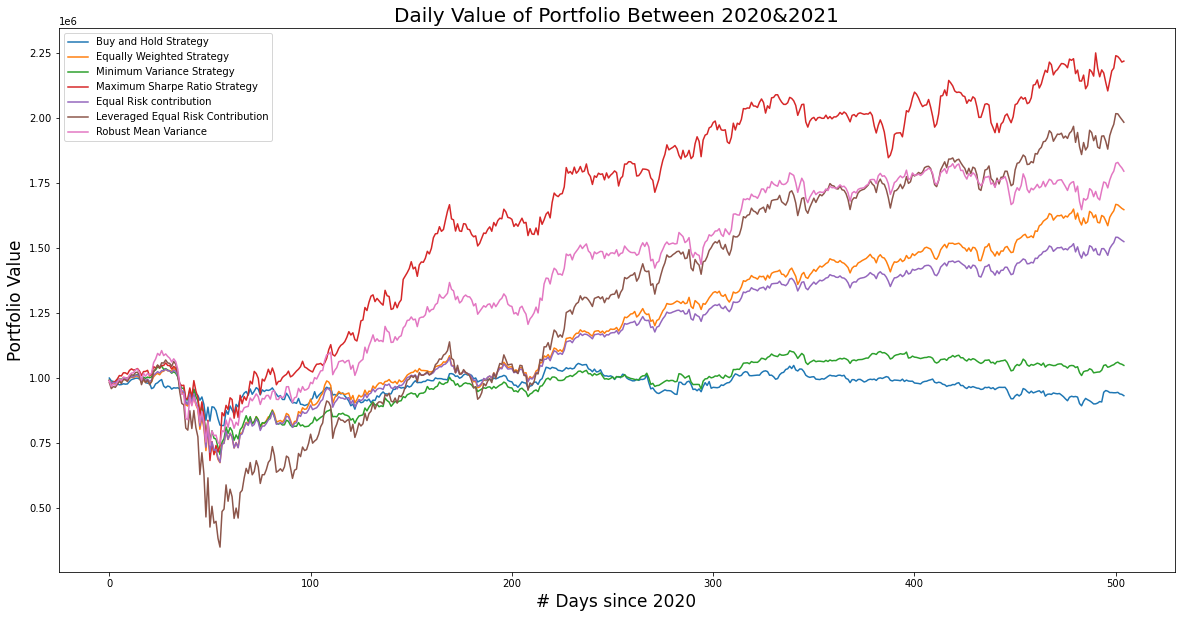

In [154]:
# Plot the daily value of my portfolio
plt.figure(figsize = (20, 10))
plt.plot(portf_value[0],label = 'Buy and Hold Strategy')
plt.plot(portf_value[1],label = 'Equally Weighted Strategy')
plt.plot(portf_value[2],label = 'Minimum Variance Strategy')
plt.plot(portf_value[3],label = 'Maximum Sharpe Ratio Strategy')
plt.plot(portf_value[4],label = 'Equal Risk contribution')
plt.plot(portf_value[5],label ='Leveraged Equal Risk Contribution')
plt.plot(portf_value[6],label = 'Robust Mean Variance')
plt.legend()
# Set the title and title of the axis for my plot
plt.title('Daily Value of Portfolio Between 2020&2021', fontsize = 20)
plt.ylabel('Portfolio Value', fontsize = 17)
plt.xlabel('# Days since 2020', fontsize = 17)
plt.show()

#### Plot one chart in Python that illustrates maximum drawdown of your portfolio (for each of the seven trading strategies) for each of the 12 periods (years 2020 and 2021) using daily prices provided.

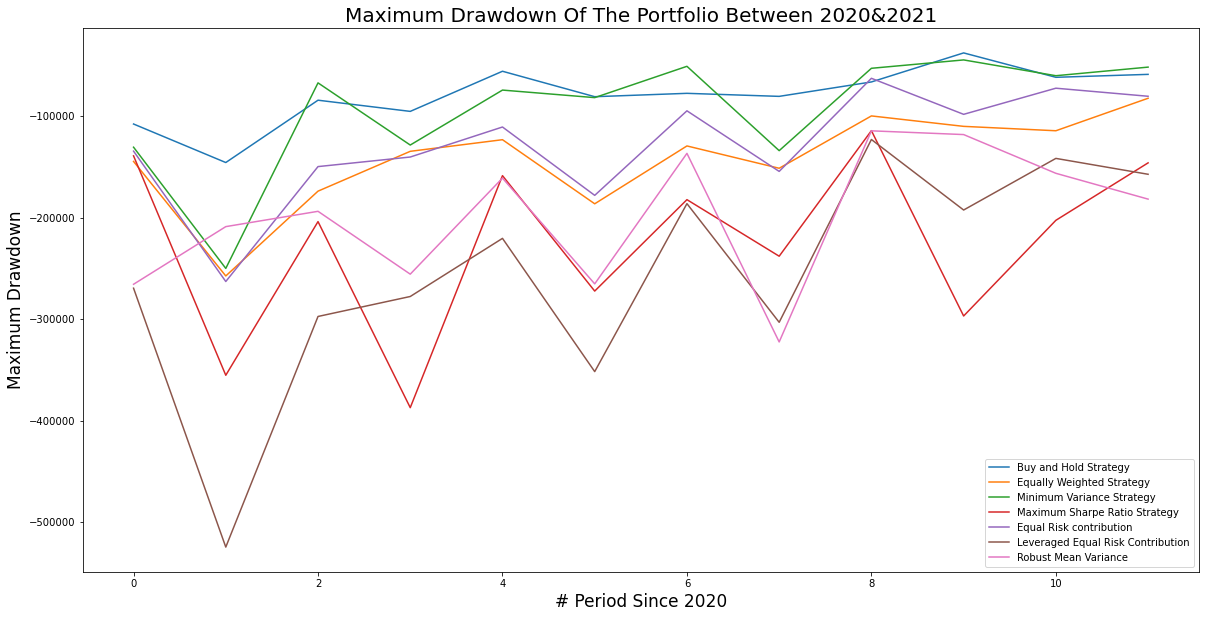

In [155]:
plt.figure(figsize = (20, 10))
plt.plot(MDD[0],label = 'Buy and Hold Strategy')
plt.plot(MDD[1],label = 'Equally Weighted Strategy')
plt.plot(MDD[2],label = 'Minimum Variance Strategy')
plt.plot(MDD[3],label = 'Maximum Sharpe Ratio Strategy')
plt.plot(MDD[4],label = 'Equal Risk contribution')
plt.plot(MDD[5],label = 'Leveraged Equal Risk Contribution')
plt.plot(MDD[6],label = 'Robust Mean Variance')
plt.legend()
# Set the title and title of the axis for my plot
plt.title('Maximum Drawdown Of The Portfolio Between 2020&2021', fontsize = 20)
plt.ylabel('Maximum Drawdown', fontsize = 17)
plt.xlabel('# Period Since 2020', fontsize = 17)
plt.show()

#### Plot one chart in Python to show dynamic changes in portfolio allocations under strat-egy 7. In each chart, x-axis represents the rolling up time horizon, y-axis denotes portfolio weights between 0 and 1, and distinct lines display the position of selected assets over time periods. Does your robust portfolio selection strategy reduce trading as compared with strategies 3 and 4 that you have implemented in Assignment 1?

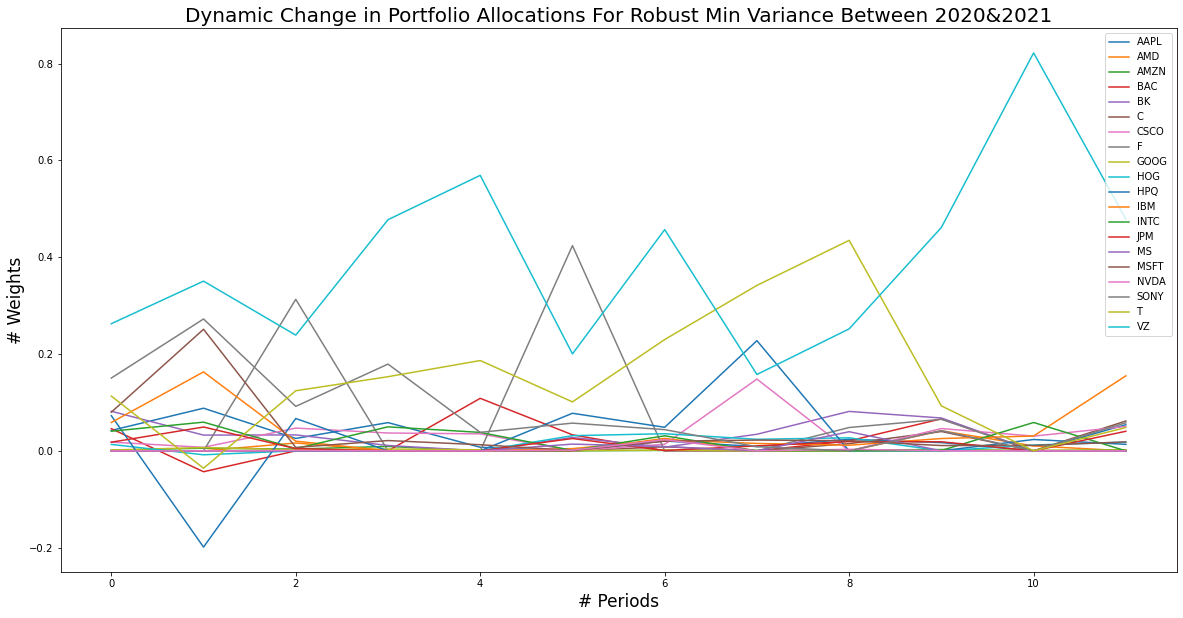

In [156]:
# Plot dynamic changes in portfolio allocations under strategy 7
w_rMV = []
total_period = N_periods + 1
# Return shares and cash(x_optimal, cash_optimal) for min variance portfolio
x[6, period - 1], cash[6, period - 1], interest[6, period - 1] = fh_array[6](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, total_period):
    sum_share_mv = sum(x[6, period - 1])
    period_weight = x[6, period - 1]/sum_share_mv
    w_rMV.append(period_weight)
# Find stock names
stock_name = df.columns[1:]
# Create dataframe
df_weight = pd.DataFrame(np.array(w_rMV), columns = stock_name)
df_weight.plot(figsize = (20,10))
plt.title('Dynamic Change in Portfolio Allocations For Robust Min Variance Between 2020&2021', fontsize = 20)
plt.xlabel('# Periods', fontsize = 17)
plt.ylabel('# Weights', fontsize = 17)
plt.show()

#### Dynamic Changes in Min-Var Optimization over year 2020-2021

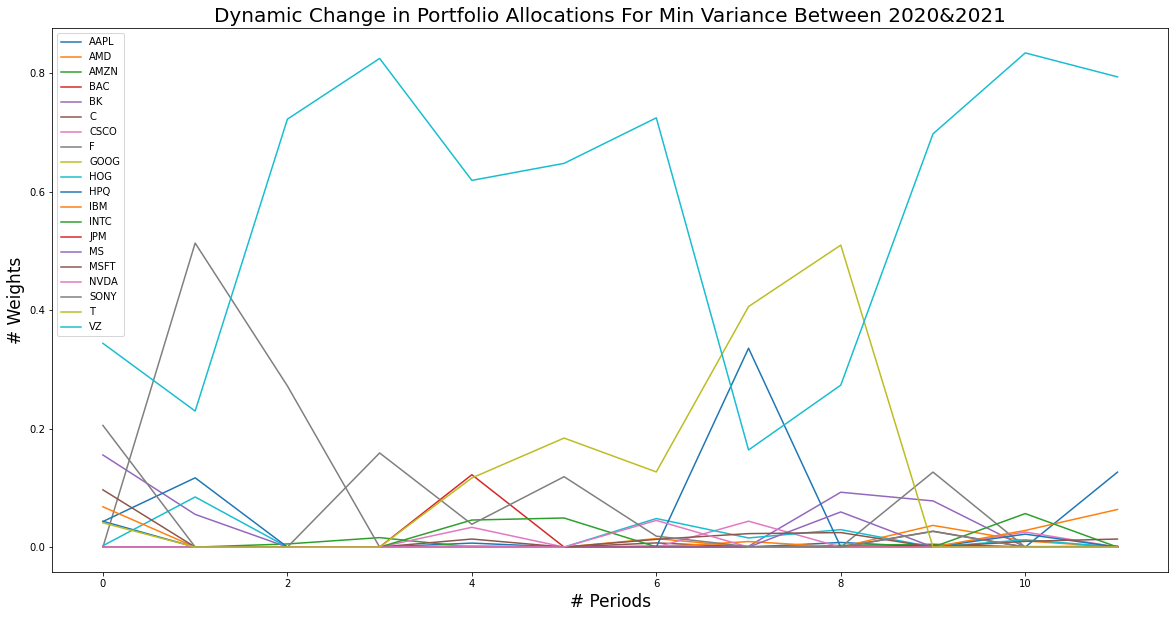

In [157]:
# Plot dynamic changes in portfolio allocations for min variance
weight_list_mv = []
total_period = N_periods + 1
# Return shares and cash(x_optimal, cash_optimal) for min variance portfolio
x[2, period - 1], cash[2, period - 1], interest[2, period - 1] = fh_array[2](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, total_period):
    sum_share_mv = sum(x[2, period - 1])
    period_weight = x[2, period - 1]/sum_share_mv
    weight_list_mv.append(period_weight)
# Find stock names
stock_name = df.columns[1:]
# Create dataframe
df_weight = pd.DataFrame(np.array(weight_list_mv), columns = stock_name)
df_weight.plot(figsize = (20,10))
plt.title('Dynamic Change in Portfolio Allocations For Min Variance Between 2020&2021', fontsize = 20)
plt.xlabel('# Periods', fontsize = 17)
plt.ylabel('# Weights', fontsize = 17)
plt.show()

#### Dynamic Changes in Maximum Sharpe Ratio Strategy over year 2020-2021

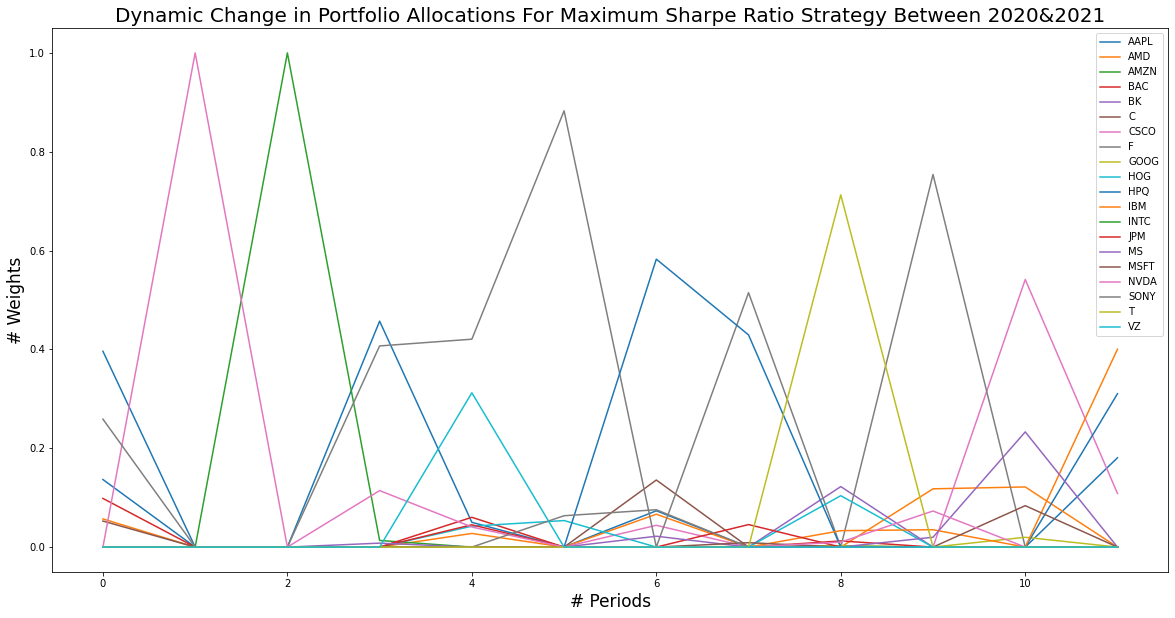

In [158]:
# Plot dynamic changes in portfolio allocations for Maximum Sharpe Ratio Strategy
weight_list_max_sharp = []
total_period = N_periods + 1
# Return shares and cash(x_optimal, cash_optimal) for Maximum Sharpe Ratio Strategy
x[3, period - 1], cash[3, period - 1], interest[3, period - 1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, total_period):
    sum_share_ms = sum(x[3, period-1])
    period_weight = x[3, period-1]/sum_share_ms
    weight_list_max_sharp.append(period_weight)
# Find stock names
stock_name = df.columns[1:]
# Create dataframe
df_weight = pd.DataFrame(np.array(weight_list_max_sharp),columns=stock_name)
df_weight.plot(figsize = (20,10))
plt.title('Dynamic Change in Portfolio Allocations For Maximum Sharpe Ratio Strategy Between 2020&2021', fontsize = 20)
plt.xlabel('# Periods', fontsize = 17)
plt.ylabel('# Weights', fontsize = 17)
plt.show()

###Robust neab-variance strategy is a well tradeoff
###Discuss possible improvements to your trading strategies
###Combinning Equal weight&buy and hold, no need to rebalance

In [159]:
# Initial portfolio value
port_value_initial = 1000000
cur_prices_initial = data_prices[0,:] 
# Set the number of stock euqal to 20 
num_stock = 20
# Equal weight
weight_equal = np.ones((20))/num_stock
value_each_stock_initial = weight_equal * port_value_initial
x_optimal_inital = np.floor(value_each_stock_initial / cur_prices) # Calculate the shares
x_optimal_inital

array([ 336.,  399.,   15., 1049.,  837.,  723.,  896., 2813.,   17.,
       1261., 1610.,  419., 1023.,  296.,  484.,  152.,  193.,  412.,
       2010.,  955.])

In [160]:
def strat_buy_and_hold_with_equal_weight(x_init, cash_init, mu, Q, cur_prices):
    
    x_init = np.array(x_init)
    # Calculate the portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    x_optimal = x_optimal_inital
    # Find the transcation cost 
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    # Find how much cash we left in the portfilio
    cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost
        
    return x_optimal, cash_optimal

### Testing the output given input data file - 2008&2009

In [161]:
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5% 
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Max Sharpe Ratio Portfolio', 'Equal Risk Contri Portfolio', 'Leveraged ERC Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.zeros((N_strat, N_periods),dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], interest[strategy,period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
        
      if cash[strategy, period-1] < 0:
          if cash[5,0]<0:
              port_value = (np.dot(cur_prices,curr_positions) + curr_cash) * 2 
          else:
              port_value = np.dot(cur_prices,curr_positions) + curr_cash
                
          ratio = x[strategy, period-1]/sum(x[strategy, period-1])
          cash_neg = abs(cash[strategy, period-1])*ratio
          position_neg = np.ceil(cash_neg/cur_prices)
          x[strategy, period-1] = x[strategy, period-1] - position_neg
          tran_cost_new = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
          curr_val = np.dot(cur_prices,x[strategy, period-1])
          cash[strategy, period-1] = port_value - curr_val - tran_cost_new - interest[strategy,period-1]

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      if strategy ==5:
          portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
          portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      MDD[strategy, period-1] = (min(portf_value[strategy][day_ind_start:day_ind_end+1])-max(portf_value[strategy][day_ind_start:day_ind_end+1]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381649.89, value end = $ 326929.57
  Strategy "Minimum Variance Portfolio", value begin = $ 383262.49, value end = $ 327144.09
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constr

/var/folders/k9/v7lydvwn3cng806yx8gl85ww0000gn/T/ipykernel_57765/1214226362.py:15: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
/Users/jialinshang/opt/anaconda3/lib/python3.9/site-packages/cyipopt/utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)
/var/folders/k9/v7lydvwn3cng806yx8gl85ww0000gn/T/ipykernel_57765/3452256469.py:24: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)


  Strategy "Robust Optimization Portfolio", value begin = $ 380761.98, value end = $ 265600.12

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 322097.69, value end = $ 354821.22
  Strategy "Minimum Variance Portfolio", value begin = $ 322718.41, value end = $ 365547.71
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 325785.77, value end = $ 344234.61
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only

  Strategy "Minimum Variance Portfolio", value begin = $ 372947.72, value end = $ 351399.81
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 349025.01, value end = $ 312518.46
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with onl

   2  1.0440153e-08 0.00e+00 1.34e-11  -2.4 1.12e-06    -  1.00e+00 2.50e-01f  3
   3  1.0440083e-08 0.00e+00 2.17e-17  -3.6 1.41e-07    -  1.00e+00 1.00e+00f  1
   4  1.0438830e-08 0.00e+00 7.03e-16  -5.4 2.51e-06    -  1.00e+00 1.00e+00f  1
   5  1.0360841e-08 0.00e+00 2.64e-12  -8.1 1.56e-04    -  1.00e+00 1.00e+00f  1
   6  4.3892742e-09 0.00e+00 2.38e-08  -9.2 1.15e-02    -  1.00e+00 1.00e+00f  1
   7  1.6768330e-09 0.00e+00 2.02e-08 -10.8 7.29e-03    -  1.00e+00 1.00e+00f  1
   8  7.0897590e-10 0.00e+00 1.30e-08 -11.0 6.68e-03    -  1.00e+00 1.00e+00f  1
   9  2.2511509e-10 0.00e+00 1.58e-08 -11.0 8.68e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1123835e-10 0.00e+00 1.61e-08 -11.0 9.91e-03    -  1.00e+00 5.00e-01f  2
  11  6.4326878e-11 0.00e+00 1.89e-09 -11.0 1.30e-03    -  1.00e+00 1.00e+00f  1
  12  4.7659988e-11 0.00e+00 1.96e-09 -11.0 5.54e-04    -  1.00e+00 1.00e+00f  1
  13  2.2744706e-11 0.00e+00

  11  3.4307924e-09 0.00e+00 2.58e-07 -11.0 1.61e-02    -  1.00e+00 1.00e+00f  1
  12  1.1723042e-09 0.00e+00 5.35e-08 -11.0 7.60e-03    -  1.00e+00 1.00e+00f  1
  13  9.9493057e-10 0.00e+00 2.02e-08 -11.0 2.23e-03    -  1.00e+00 1.00e+00f  1
  14  7.5233622e-10 0.00e+00 1.01e-08 -11.0 2.30e-03    -  1.00e+00 1.00e+00f  1
  15  4.1391106e-10 0.00e+00 3.21e-08 -11.0 6.83e-03    -  1.00e+00 1.00e+00f  1
  16  3.5272059e-10 0.00e+00 2.97e-08 -11.0 1.80e-02    -  1.00e+00 2.50e-01f  3
  17  3.2412935e-10 0.00e+00 2.92e-08 -11.0 4.97e-03    -  1.00e+00 5.00e-01f  2
  18  2.2934847e-10 0.00e+00 3.72e-09 -11.0 2.31e-03    -  1.00e+00 1.00e+00f  1
  19  2.0366214e-10 0.00e+00 4.81e-09 -11.0 6.81e-04    -  1.00e+00 1.00e+00f  1
  Strategy "Equal Risk Contri Portfolio", value begin = $ 326353.89, value end = $ 242802.05

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   2.0366214497102452e-10    2.0366214497102452e-10

  15  1.6391771e-09 0.00e+00 3.03e-07 -11.0 1.07e-03    -  1.00e+00 1.00e+00f  1
  16  1.5761220e-09 0.00e+00 1.09e-07 -11.0 6.19e-04    -  1.00e+00 5.00e-01f  2
  17  1.3262216e-09 0.00e+00 5.19e-08 -11.0 2.59e-04    -  1.00e+00 1.00e+00f  1
  18  6.9470344e-10 0.00e+00 1.17e-07 -11.0 8.84e-04    -  1.00e+00 1.00e+00f  1
  19  2.2738569e-10 0.00e+00 2.01e-07 -11.0 1.79e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.6176416e-10 0.00e+00 1.83e-07 -11.0 9.28e-04    -  1.00e+00 5.00e-01f  2
  21  7.5288399e-11 0.00e+00 1.14e-07 -11.0 3.67e-04    -  1.00e+00 1.00e+00f  1
  22  7.3397372e-11 0.00e+00 5.59e-08 -11.0 4.96e-04    -  1.00e+00 2.50e-01f  3
  23  6.6299241e-11 0.00e+00 1.04e-08 -11.0 1.08e-04    -  1.00e+00 1.00e+00f  1
  24  5.3732683e-11 0.00e+00 9.94e-09 -11.0 5.77e-05    -  1.00e+00 1.00e+00f  1
  25  6.8807462e-12 0.00e+00 6.05e-08 -11.0 5.76e-04    -  1.00e+00 1.00e+00f  1
  Strategy "Equal Risk Contr

  24  3.0566072e-11 0.00e+00 3.29e-08 -11.0 6.05e-05    -  1.00e+00 2.50e-01f  3
  Strategy "Equal Risk Contri Portfolio", value begin = $ 221917.82, value end = $ 189453.82
Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:   3.0566072120169198e-11    3.0566072120169198e-11
Dual infeasibility......:   3.2940030815267682e-08    3.2940030815267682e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0010874663718397e-11    1.0010874663718397e-11
Overall NLP error.......:   3.2940030815267682e-08    3.2940030815267682e-08


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 25
Number of equality constraint evaluations            = 47
Number of inequality constraint evaluations          = 0
Number of equality constraint 

  19  2.7213807e-09 0.00e+00 4.41e-07 -11.0 1.10e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.9554521e-09 0.00e+00 2.18e-07 -11.0 1.43e-02    -  1.00e+00 5.00e-01f  2
  21  1.7730166e-09 0.00e+00 1.43e-07 -11.0 9.54e-03    -  1.00e+00 1.25e-01f  4
  22  3.4775127e-10 0.00e+00 5.61e-08 -11.0 7.11e-03    -  1.00e+00 1.00e+00f  1
  23  2.8907449e-10 0.00e+00 1.31e-07 -11.0 6.10e-03    -  1.00e+00 6.25e-02f  5
  24  2.0667782e-10 0.00e+00 2.24e-08 -11.0 3.82e-04    -  1.00e+00 1.00e+00f  1
  25  1.3829337e-10 0.00e+00 1.25e-08 -11.0 5.15e-04    -  1.00e+00 1.00e+00f  1
  26  1.1714725e-10 0.00e+00 4.19e-08 -11.0 1.02e-03    -  1.00e+00 5.00e-01f  2
  27  1.0197699e-10 0.00e+00 6.34e-08 -11.0 1.00e-03    -  1.00e+00 5.00e-01f  2
  28  9.0014195e-11 0.00e+00 2.31e-08 -11.0 3.80e-04    -  1.00e+00 5.00e-01f  2
  29  8.7652448e-11 0.00e+00 7.95e-09 -11.0 2.69e-04    -  1.00e+00 5.00e-01f  2
  Strategy "Equal Risk Contr

   1  1.8226393e-06 0.00e+00 1.72e-06  -6.3 1.42e-06    -  9.90e-01 1.00e+00f  1
   2  1.8200168e-06 0.00e+00 1.45e-07  -2.4 1.37e-04    -  1.00e+00 2.50e-01f  3
   3  1.8186980e-06 0.00e+00 2.14e-11  -3.6 1.72e-05    -  1.00e+00 1.00e+00f  1
   4  1.7956177e-06 0.00e+00 7.19e-10  -9.6 3.02e-04    -  9.99e-01 1.00e+00f  1
   5  7.2614086e-07 0.00e+00 2.92e-06  -8.0 1.53e-02    -  1.00e+00 1.00e+00f  1
   6  3.0803506e-07 0.00e+00 2.09e-06  -9.3 8.99e-03    -  1.00e+00 1.00e+00f  1
   7  1.1592303e-07 0.00e+00 9.74e-07 -10.4 8.20e-03    -  1.00e+00 1.00e+00f  1
   8  4.8888705e-08 0.00e+00 4.50e-07 -11.0 6.58e-03    -  1.00e+00 1.00e+00f  1
   9  2.8277028e-08 0.00e+00 5.21e-07 -10.7 6.07e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3639955e-08 0.00e+00 9.83e-07 -10.4 1.09e-02    -  1.00e+00 5.00e-01f  2
  11  1.5631213e-08 0.00e+00 1.59e-07 -11.0 4.60e-03    -  1.00e+00 1.00e+00f  1
  12  1.0105088e-08 0.00e+00

  Strategy "Buy and Hold", value begin = $ 286766.63, value end = $ 298338.27
  Strategy "Equally Weighted Portfolio", value begin = $ 272967.79, value end = $ 321758.02
  Strategy "Minimum Variance Portfolio", value begin = $ 319907.28, value end = $ 341210.60
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 180487.01, value end = $ 195121.88
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:       

  Strategy "Minimum Variance Portfolio", value begin = $ 333055.45, value end = $ 349798.81
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 186739.28, value end = $ 186512.54
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with onl

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4105834e-09 0.00e+00 2.00e-08 -11.0 1.88e-02    -  1.00e+00 1.00e+00f  1
  11  1.0623411e-09 0.00e+00 1.05e-08 -11.0 7.00e-03    -  1.00e+00 1.00e+00f  1
  12  8.9614752e-10 0.00e+00 1.18e-08 -11.0 5.97e-03    -  1.00e+00 1.00e+00f  1
  13  7.7545764e-10 0.00e+00 7.05e-09 -11.0 3.60e-03    -  1.00e+00 1.00e+00f  1
  14  6.4914169e-10 0.00e+00 8.17e-09 -11.0 7.34e-03    -  1.00e+00 1.00e+00f  1
  15  4.4010254e-10 0.00e+00 5.57e-09 -11.0 8.50e-03    -  1.00e+00 1.00e+00f  1
  16  4.3857695e-10 0.00e+00 1.81e-08 -11.0 1.92e-02    -  1.00e+00 1.00e+00f  1
  17  2.6544674e-10 0.00e+00 1.38e-08 -11.0 7.53e-03    -  1.00e+00 1.00e+00f  1
  18  2.1579786e-10 0.00e+00 6.14e-09 -11.0 5.63e-03    -  1.00e+00 1.00e+00f  1
  Strategy "Equal Risk Contri Portfolio", value begin = $ 331102.88, value end = $ 370084.81  19  1.7898029e-10 0.00e+00 2.01e-09 -11.0 1.99e-03    -  1.00e+00 1.00e+00f  1


Number of Itera

#### Plot one chart in Python that illustrates the daily value of your portfolio (for each of the seven trading strategies) over the years 2008 and 2009 using daily prices that you have downloaded.

                     = 0.073

EXIT: Solved To Acceptable Level.


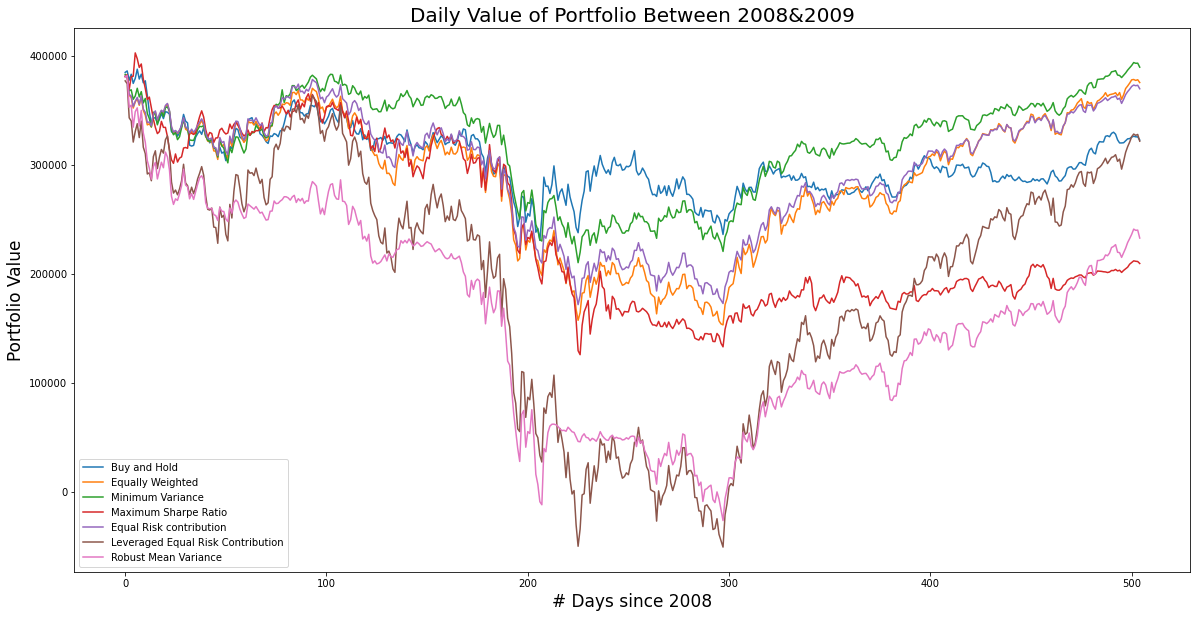

In [162]:
plt.figure(figsize = (20, 10))
plt.plot(portf_value[0], label = 'Buy and Hold')
plt.plot(portf_value[1], label = 'Equally Weighted')
plt.plot(portf_value[2], label = 'Minimum Variance')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio')
plt.plot(portf_value[4], label = 'Equal Risk contribution')
plt.plot(portf_value[5], label = 'Leveraged Equal Risk Contribution')
plt.plot(portf_value[6], label = 'Robust Mean Variance')
plt.legend()
# Set the title and title of the axis for my plot
plt.title('Daily Value of Portfolio Between 2008&2009', fontsize = 20)
plt.ylabel('Portfolio Value', fontsize = 17)
plt.xlabel('# Days since 2008', fontsize = 17)
plt.show()

#### Plot one chart in Python that illustrates maximum drawdown of your portfolio (for each of the seven trading strategies) for each of the 12 periods (years 2008 and 2009) using daily prices provided. Include the chart in your report.

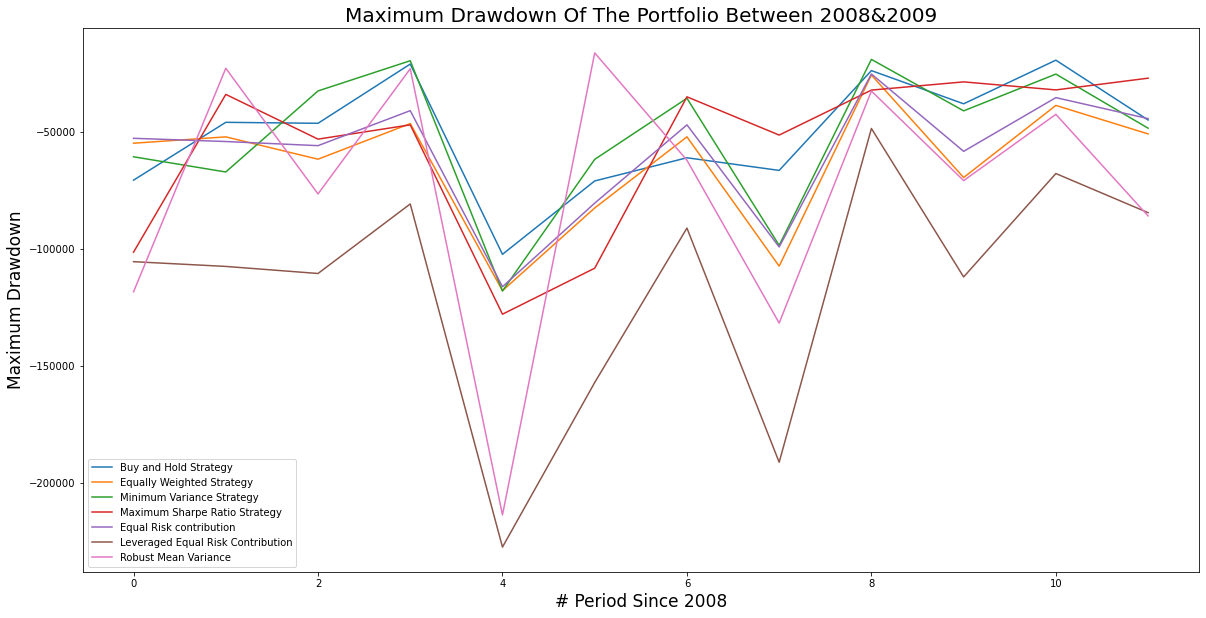

In [163]:
plt.figure(figsize = (20, 10))
plt.plot(MDD[0], label = 'Buy and Hold Strategy')
plt.plot(MDD[1], label = 'Equally Weighted Strategy')
plt.plot(MDD[2], label = 'Minimum Variance Strategy')
plt.plot(MDD[3], label = 'Maximum Sharpe Ratio Strategy')
plt.plot(MDD[4], label = 'Equal Risk contribution')
plt.plot(MDD[5], label = 'Leveraged Equal Risk Contribution')
plt.plot(MDD[6], label = 'Robust Mean Variance')
plt.legend()
# Set the title and title of the axis for my plot
plt.title('Maximum Drawdown Of The Portfolio Between 2008&2009', fontsize = 20)
plt.ylabel('Maximum Drawdown', fontsize = 17)
plt.xlabel('# Period Since 2008', fontsize = 17)
plt.show()

#### Plot three charts in Python for strategies 3, 4 and 7 to show dynamic changes in portfolio allocations using the new data set. Does your robust portfolio selection strategy reduce trading as compared with the strategies 3 and 4?

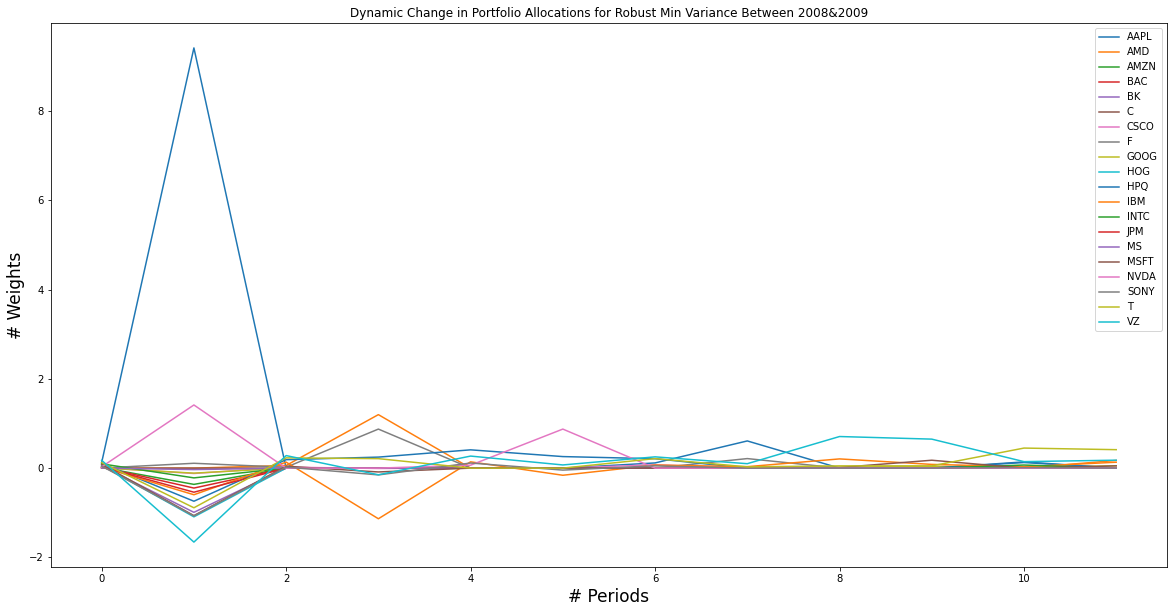

In [164]:
# Plot dynamic changes in portfolio allocations for Maximum Sharpe Ratio Strategy
w_rMV = []
total_period = N_periods + 1
# Return shares and cash(x_optimal, cash_optimal) for Maximum Sharpe Ratio Strategy
x[6, period - 1], cash[6, period - 1], interest[6, period - 1] = fh_array[6](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, total_period):
    sum_share_mv = sum(x[6, period - 1])
    period_weight = x[6, period - 1]/sum_share_mv
    w_rMV.append(period_weight)
# Find stock names
stock_name = df.columns[1:]
# Create dataframe
df_weight = pd.DataFrame(np.array(w_rMV),columns=stock_name)
df_weight.plot(figsize = (20,10))
plt.title('Dynamic Change in Portfolio Allocations for Robust Min Variance Between 2008&2009', fontsize = 20)
plt.xlabel('# Periods', fontsize = 17)
plt.ylabel('# Weights', fontsize = 17)
plt.show()

### Dynamic Changes in Min-Var Optimization over year 2008 and 2009

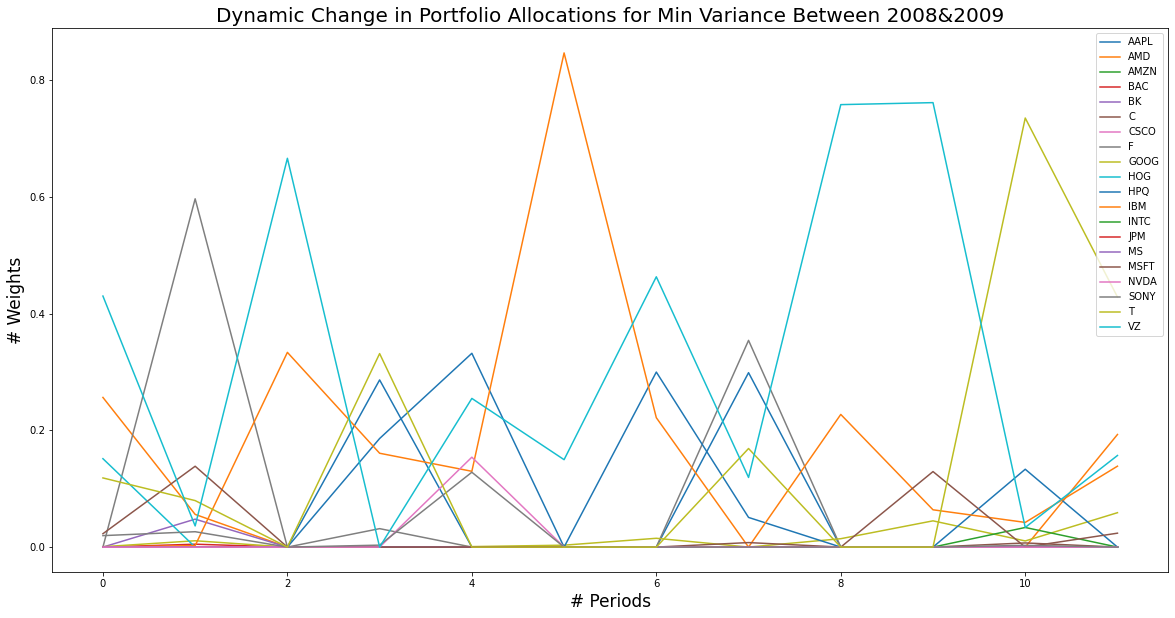

In [165]:
# Plot dynamic changes in portfolio allocations for Maximum Sharpe Ratio Strategy
weight_list_mv = []
total_period = N_periods + 1
# Return shares and cash(x_optimal, cash_optimal) for Maximum Sharpe Ratio Strategy
x[2, period - 1], cash[2, period-1], interest[2, period-1] = fh_array[2](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, total_period):
    sum_share_mv = sum(x[2, period-1])
    period_weight = x[2, period-1]/sum_share_mv
    weight_list_mv.append(period_weight)
# Find stock names
stock_name = df.columns[1:]
# Create dataframe
df_weight = pd.DataFrame(np.array(weight_list_mv),columns=stock_name)
df_weight.plot(figsize = (20,10))
plt.title('Dynamic Change in Portfolio Allocations for Min Variance Between 2008&2009', fontsize = 20)
plt.xlabel('# Periods', fontsize = 17)
plt.ylabel('# Weights', fontsize = 17)
plt.show()

###Dynamic Changes in Maximum Sharpe Ratio Strategy over year 2008 and 2009

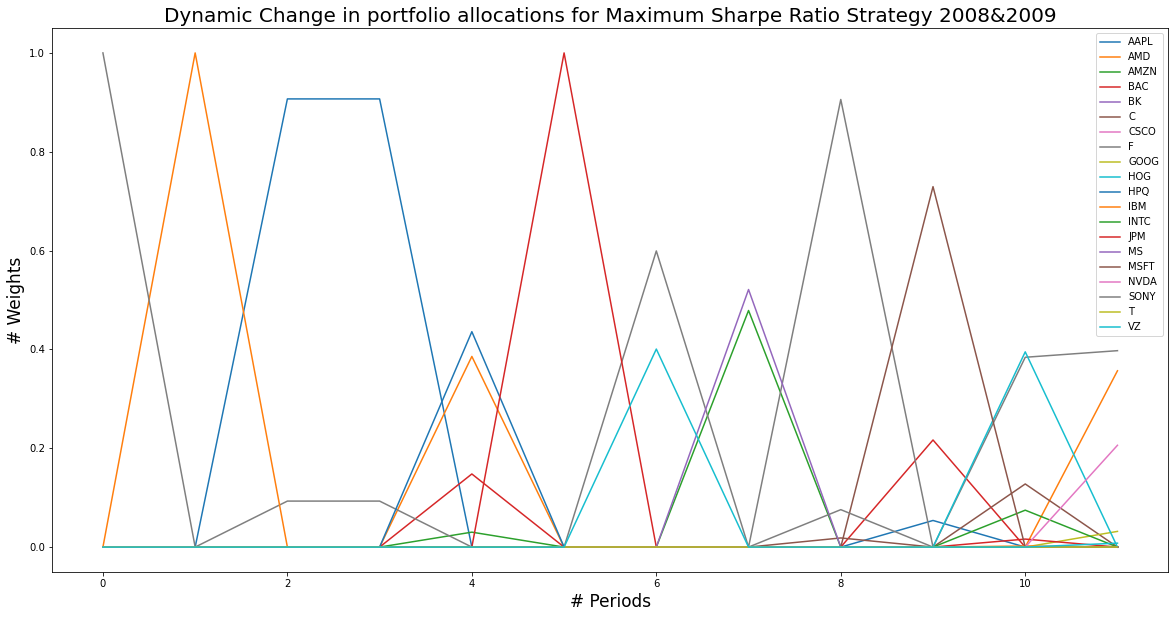

In [166]:
# Plot dynamic changes in portfolio allocations for Maximum Sharpe Ratio Strategy
weight_list_max_sharp = []
total_period = N_periods+1
# Return shares and cash(x_optimal, cash_optimal) for Maximum Sharpe Ratio Strategy
x[3, period-1], cash[3, period-1], interest[3, period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, total_period):
    sum_share_ms = sum(x[3, period-1])
    period_weight = x[3, period-1]/sum_share_ms
    weight_list_max_sharp.append(period_weight)
# Find stock names
stock_name = df.columns[1:]
# Create dataframe
df_weight = pd.DataFrame(np.array(weight_list_max_sharp),columns=stock_name)
df_weight.plot(figsize = (20,10))
plt.title('Dynamic Change in portfolio allocations for Maximum Sharpe Ratio Strategy 2008&2009', fontsize = 20)
plt.xlabel('# Periods', fontsize = 17)
plt.ylabel('# Weights', fontsize = 17)
plt.show()

### Testing the output given input data file - 2022

In [167]:
# Input file
input_file_prices = 'Daily_closing_prices2022.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

df

,Date,AAPL,AMD,AMZN,BAC,BK,C,CSCO,F,GOOG,...,HPQ,IBM,INTC,JPM,MS,MSFT,NVDA,SONY,T,VZ
0,11/01/2021,147.884644,125.230003,165.905502,46.537212,57.735558,66.266304,53.961533,17.296173,143.774002,...,30.082209,113.507439,46.759529,163.397614,99.660919,325.716522,257.997131,121.239998,17.578903,49.424942
1,11/02/2021,148.936981,127.629997,165.637497,46.566391,57.648983,65.304825,55.423599,17.353989,145.863007,...,29.851177,113.417542,47.052071,164.042358,100.293373,329.434784,263.731079,123.320000,17.481895,49.070232
2,11/03/2021,150.396378,130.529999,169.199997,47.042946,57.802895,65.685608,55.452454,17.951403,146.789993,...,30.082209,114.271469,47.552223,164.100098,98.328903,330.295166,265.699005,123.139999,17.447250,49.415604
3,11/04/2021,149.870193,137.500000,173.850006,46.031479,56.812096,63.781670,54.942657,18.712629,148.682999,...,30.159220,113.623474,47.806889,161.944534,95.626556,332.708099,297.695129,122.650002,17.183947,48.398174
4,11/05/2021,150.407074,136.339996,175.949493,45.681358,56.581230,63.772148,54.894566,18.587366,149.240997,...,30.756052,116.218437,48.386539,161.713593,95.703224,332.332275,297.205627,123.220001,17.391819,48.762211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,12/23/2022,131.860001,64.519997,85.250000,32.470001,44.312298,43.827736,47.103645,11.360000,89.809998,...,26.760000,141.649994,25.775923,130.317398,85.421013,238.729996,152.059998,76.940002,18.049366,37.815506
290,12/27/2022,130.029999,63.270000,83.040001,32.529999,44.481010,43.956470,47.153248,11.200000,87.930000,...,27.070000,142.419998,25.627729,130.774033,84.379410,236.960007,141.210007,75.540001,18.197231,38.642506
291,12/28/2022,126.040001,62.570000,81.820000,32.770000,44.292450,44.184223,46.696896,10.950000,86.459999,...,26.540001,140.020004,25.232544,131.488754,83.784210,234.529999,140.360001,74.849998,17.960648,38.209316
292,12/29/2022,129.610001,64.820000,84.180000,33.139999,45.314655,44.718948,47.123486,11.540000,88.949997,...,27.040001,141.059998,25.894478,132.243179,84.557968,241.009995,146.029999,76.690002,18.187374,38.652348


In [168]:
# Input file
input_file_prices = 'Daily_closing_prices2022.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2022
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
N_strat = len(strategy_functions)  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 22:
       cur_year  = 22 + math.floor(period/7)
   else:
       cur_year  = 2022 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], some_other_variable = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 890077.15


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 890077.15, value end = $ 924072.93
  Strategy "Equally Weighted Portfolio", value begin = $ 881961.28, value end = $ 801851.94
  Strategy "Mininum Variance Portfolio", value begin = $ 885881.15, value end = $ 863280.14
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 881177.50, value end = $ 799415.38
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality co

/var/folders/k9/v7lydvwn3cng806yx8gl85ww0000gn/T/ipykernel_57765/1214226362.py:15: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
/Users/jialinshang/opt/anaconda3/lib/python3.9/site-packages/cyipopt/utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)
/var/folders/k9/v7lydvwn3cng806yx8gl85ww0000gn/T/ipykernel_57765/3452256469.py:24: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)


  Strategy "Robust Optimization Portfolio", value begin = $ 156735.94, value end = $ 146673.25

Period 2: start date 03/01/2022, end date 04/29/2022
  Strategy "Buy and Hold", value begin = $ 921940.14, value end = $ 807230.89
  Strategy "Equally Weighted Portfolio", value begin = $ 782181.39, value end = $ 705033.91
  Strategy "Mininum Variance Portfolio", value begin = $ 854737.85, value end = $ 782489.51
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 782791.44, value end = $ 692166.87
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with 

  Strategy "Mininum Variance Portfolio", value begin = $ 785836.88, value end = $ 820474.96
                     = 0.063

EXIT: Solved To Acceptable Level.
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 685687.53, value end = $ 733764.28
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lowe

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 730871.25, value end = $ 610797.69
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alp

   3  2.2451949e-08 0.00e+00 1.73e-17  -3.6 8.33e-08    -  1.00e+00 1.00e+00f  1
   4  2.2450306e-08 0.00e+00 2.99e-16  -5.4 1.70e-06    -  1.00e+00 1.00e+00f  1
   5  2.2347350e-08 0.00e+00 1.09e-12  -8.1 1.06e-04    -  1.00e+00 1.00e+00f  1
   6  1.0413475e-08 0.00e+00 1.87e-08  -9.1 9.63e-03    -  9.92e-01 1.00e+00f  1
   7  4.9345781e-09 0.00e+00 2.60e-08 -10.5 1.10e-02    -  9.99e-01 1.00e+00f  1
   8  2.8439407e-09 0.00e+00 1.83e-08 -11.0 1.44e-02    -  1.00e+00 1.00e+00f  1
   9  1.4373878e-09 0.00e+00 2.96e-08 -11.0 2.18e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.9050316e-10 0.00e+00 2.66e-08 -11.0 7.68e-02    -  1.00e+00 5.00e-01f  2
  11  5.1578732e-10 0.00e+00 4.29e-08 -11.0 8.77e-03    -  1.00e+00 1.00e+00f  1
  12  1.8467870e-10 0.00e+00 7.76e-09 -11.0 1.37e-02    -  1.00e+00 1.00e+00f  1
  13  1.1613166e-10 0.00e+00 7.45e-09 -11.0 6.25e-03    -  1.00e+00 1.00e+00f  1
  14  6.5015797e-11 0.00e+00

   6  7.3375509e-09 0.00e+00 5.35e-08  -9.5 1.24e-02    -  9.98e-01 1.00e+00f  1
   7  3.8989254e-09 0.00e+00 4.47e-08 -11.0 5.63e-03    -  1.00e+00 1.00e+00f  1
   8  2.1457097e-09 0.00e+00 3.34e-08 -11.0 5.68e-03    -  1.00e+00 1.00e+00f  1
   9  1.0885709e-09 0.00e+00 1.46e-08 -11.0 6.47e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9463532e-10 0.00e+00 1.59e-08 -11.0 6.57e-03    -  1.00e+00 1.00e+00f  1
  11  3.7542215e-10 0.00e+00 3.19e-08 -11.0 4.84e-03    -  1.00e+00 1.00e+00f  1
  12  1.8279908e-10 0.00e+00 6.63e-09 -11.0 2.48e-03    -  1.00e+00 1.00e+00f  1
  13  1.7118182e-10 0.00e+00 5.95e-09 -11.0 1.34e-03    -  1.00e+00 1.00e+00f  1
  14  1.4133532e-10 0.00e+00 1.13e-08 -11.0 7.54e-04    -  1.00e+00 1.00e+00f  1
  15  1.3299030e-10 0.00e+00 2.14e-09 -11.0 4.77e-04    -  1.00e+00 1.00e+00f  1
  16  1.2219697e-10 0.00e+00 1.68e-09 -11.0 3.01e-04    -  1.00e+00 1.00e+00f  1
  17  5.3813161e-11 0.00e+00

In [169]:
print(len(portf_value))

7


#### Plot one chart in Python that illustrates the daily value of your portfolio (for each of the seven trading strategies) over the year 2022 using daily prices that you have downloaded. 

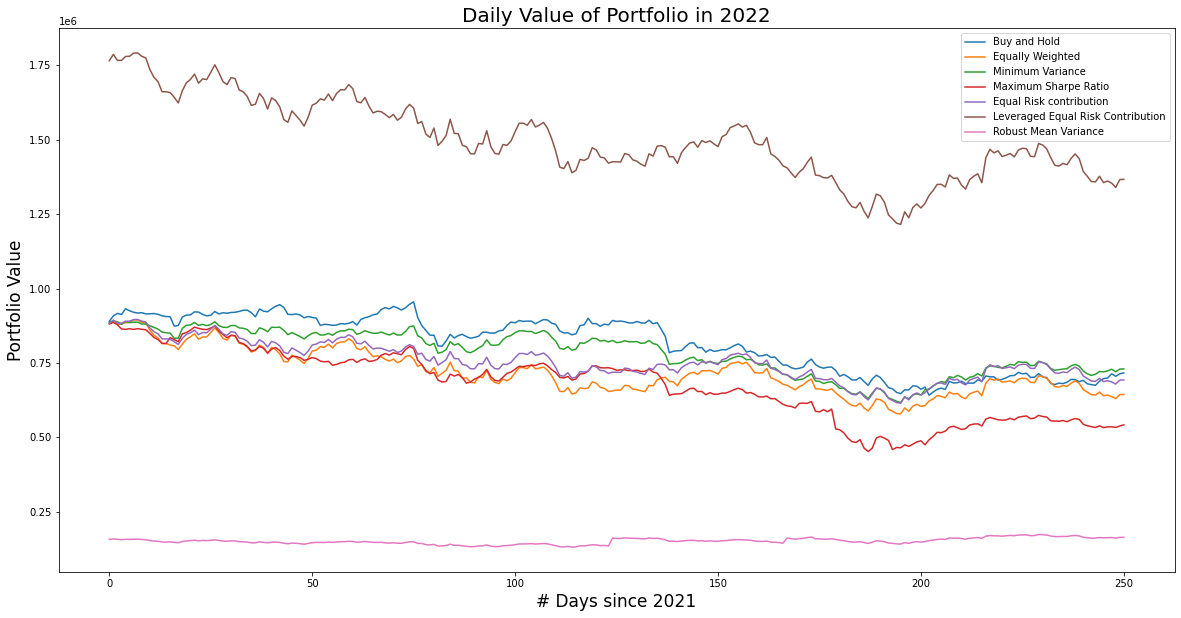

In [170]:
plt.figure(figsize = (20, 10))
plt.plot(portf_value[0], label = 'Buy and Hold')
plt.plot(portf_value[1], label = 'Equally Weighted')
plt.plot(portf_value[2], label = 'Minimum Variance')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio')
plt.plot(portf_value[4], label = 'Equal Risk contribution')
plt.plot(portf_value[5], label = 'Leveraged Equal Risk Contribution')
plt.plot(portf_value[6], label = 'Robust Mean Variance')
plt.legend()
# Set the title and title of the axis for my plot
plt.title('Daily Value of Portfolio in 2022', fontsize = 20)
plt.ylabel('Portfolio Value', fontsize = 17)
plt.xlabel('# Days since 2021', fontsize = 17)
plt.show()

#### Plot one chart in Python that illustrates maximum drawdown of your portfolio (for each of the seven trading strategies) for each of the 6 periods (year 2022) using daily prices provided. 

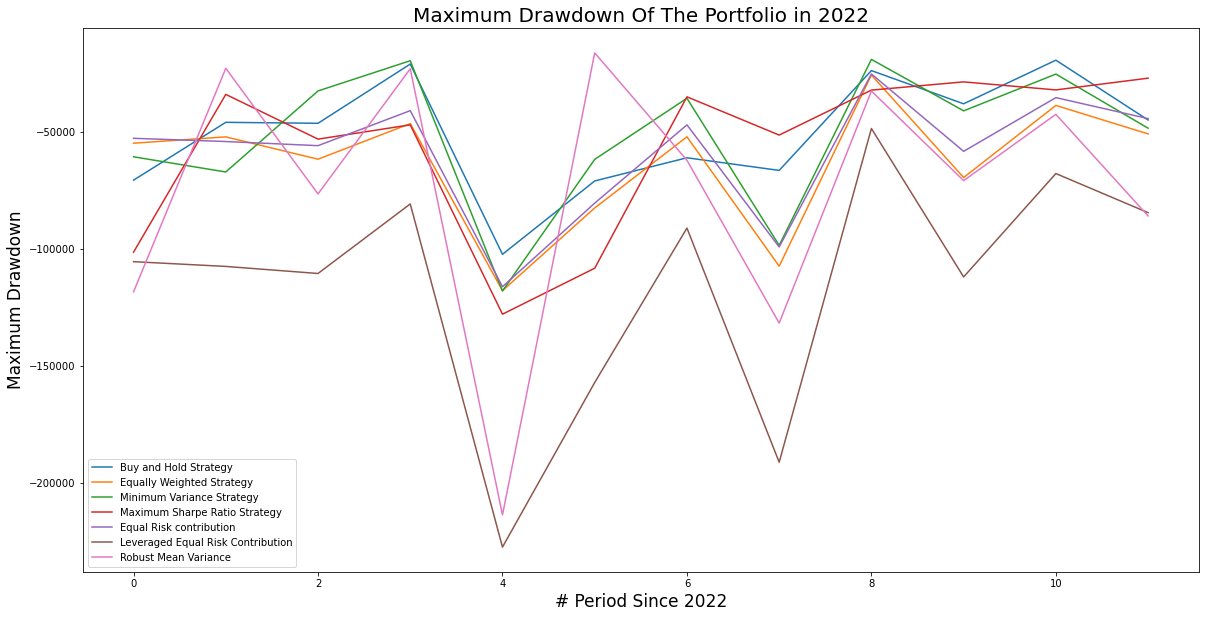

In [171]:
plt.figure(figsize = (20, 10))
plt.plot(MDD[0],label = 'Buy and Hold Strategy')
plt.plot(MDD[1],label = 'Equally Weighted Strategy')
plt.plot(MDD[2],label = 'Minimum Variance Strategy')
plt.plot(MDD[3],label = 'Maximum Sharpe Ratio Strategy')
plt.plot(MDD[4],label = 'Equal Risk contribution')
plt.plot(MDD[5],label = 'Leveraged Equal Risk Contribution')
plt.plot(MDD[6],label = 'Robust Mean Variance')
plt.legend()
# Set the title and title of the axis for my plot
plt.title('Maximum Drawdown Of The Portfolio in 2022', fontsize = 20)
plt.ylabel('Maximum Drawdown', fontsize = 17)
plt.xlabel('# Period Since 2022', fontsize = 17)
plt.show()